# Hysteresis Experiments: 

Give the existence of multiple steady-state solutions when using an elevation-dependent mass balance, lets examine the effect different choices of initial conditions have on the steady-state profiles for each of the perturbed glacier beds. 

In [1]:
import os 
import sys
import copy 
import numpy as np 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Local plotting functions
sys.path.append('../SRC/')
from utils import plot_spinup 

# Set global matplotlib style parameters
plt.rcParams.update({'font.size': 12, 
                     'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w'})

Read in the steady-state initial condition model runs: 

In [2]:
fp = '../Synthetic/hysteresis/smoothBed_SS_IC/hdf5/'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '2000a' in file])
xarrays = []

for file in files:
    #if '2.26' not in file: 
    xarrays.append(xr.open_dataset(file))

SmoothBed_SS_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(1.90, 2.051, 0.01),  name='Delta_MB'))
                       #pd.Index(data = np.delete(np.arange(2.00, 2.51, 0.01),26),  name='Delta_MB'))

# Correct for mimimum thickness
# NOTE:: This shoud have been done in the dat2h5.py file but not sure if it's working
SmoothBed_SS_IC['z_s'] = SmoothBed_SS_IC.z_s.where((SmoothBed_SS_IC.z_s - SmoothBed_SS_IC.z_b) != 10., SmoothBed_SS_IC.z_b)
SmoothBed_SS_IC["H"]   = SmoothBed_SS_IC.z_s - SmoothBed_SS_IC.z_b
# Flip the x-coordinate to more accurately match the map view representation of LK
SmoothBed_SS_IC['x'] = SmoothBed_SS_IC['x'][::-1]

Read in the reference glacier profile (observed) condition model runs: 

In [3]:
fp = '../Synthetic/hysteresis/observed_IC/hdf5/'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '2000a' in file])
xarrays = []

for file in files:
    #if '2.26' not in file: 
    xarrays.append(xr.open_dataset(file))

Observed_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(1.90, 2.051, 0.01), name='Delta_MB'))
                       #pd.Index(data = np.delete(np.arange(2.00, 2.51, 0.01),26), name='Delta_MB'))

# Correct for mimimum thickness
# NOTE:: This shoud have been done in the dat2h5.py file but not sure if it's working
Observed_IC['z_s'] = Observed_IC.z_s.where((Observed_IC.z_s - Observed_IC.z_b) != 10., Observed_IC.z_b)
Observed_IC["H"]   = Observed_IC.z_s - Observed_IC.z_b
# Flip the x-coordinate to more accurately match the map view representation of LK
Observed_IC['x']   = Observed_IC['x'][::-1]

Compute the relative (to the observed I.C.) volume for both sets of results: 

In [4]:
OIC_vol = Observed_IC.H.integrate("x")     / Observed_IC.H.sel(t=1).integrate("x")
SIC_vol = SmoothBed_SS_IC.H.integrate("x") / Observed_IC.H.sel(t=1).integrate("x")

Create a colormap and associated variables, which can be reused for multiple plots

In [5]:
cmap, norm, s_map, bounds = plot_spinup.make_colorbar(Observed_IC)

Plot the relative volume through time for both initial conditions:

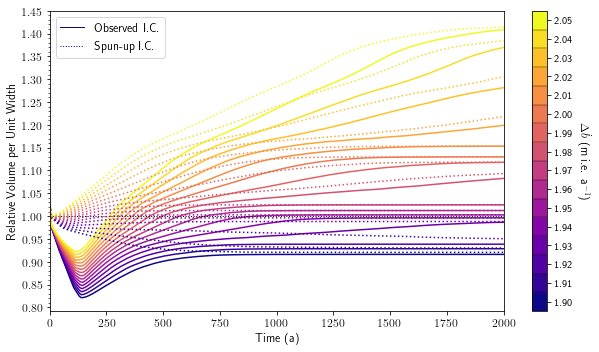

In [6]:
# Call the helper function to plot the relative volume curves 
fig, ax, cbar = plot_spinup.plot_volume(Observed_IC, precision=2, title=None)

# get the colorbar used by the helper function 
cmap, norm, s_map, bounds = plot_spinup.make_colorbar(Observed_IC)

# loop over steadt-state initial condition results and plot with dotted line 
for delta_mb in SIC_vol.Delta_MB:
    color = cmap(norm(delta_mb))
    ax.plot(SIC_vol.t[1:], SIC_vol.sel(Delta_MB=delta_mb)[1:], color=color, ls=':')
    

# aditional lines
custom_lines = [Line2D([0], [0], color=cmap(0), lw=1, ls='-'),
                Line2D([0], [0], color=cmap(0), lw=1, ls=':')]

ax.legend(custom_lines, ['Observed I.C.', 'Spun-up  I.C.'], loc=2)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0.8, 1.50, 0.05)
minor_ticks = np.arange(0.8, 1.45, 0.01)
ax.set_yticks(major_ticks);
ax.set_yticks(minor_ticks, minor=True);

# Adjust the figure size
fig.set_size_inches(9, 5)

# Adjust colorbar label fontsize 
cbar.ax.tick_params(labelsize='small')
# fig.savefig('/Users/andrewnolan/Desktop/hystersis_test.png', dpi=400, bbox_inches='tight', facecolor='w')

Next, lets plot the final relative volume per unit width ($V'(t=2000)$) for both initial conditions as a function of mass-balance offset. 

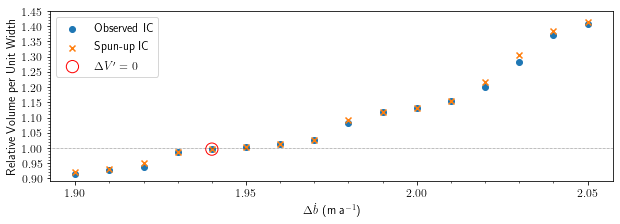

In [78]:
fig, ax = plt.subplots(1,1, figsize=(8.5,3), constrained_layout=True)

ax.scatter(OIC_vol.Delta_MB, OIC_vol.isel(t=-1),label='Observed IC')
ax.scatter(SIC_vol.Delta_MB, SIC_vol.isel(t=-1),label='Spun-up  IC',marker='x')


ax.scatter(OIC_vol.isel(Delta_MB=4).Delta_MB, 
           OIC_vol.isel(Delta_MB=4).isel(t=-1), 
           s=150, edgecolors='r', facecolor='None',
           label='$\Delta V\' = 0$')

ax.legend()

ax.axhline(1.0, ls=':', c='k', lw=0.5)

ax.set_ylabel('Relative Volume per Unit Width')
ax.set_xlabel('$\Delta \dot b$ (m a$^{-1}$)')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(1.90, 2.051, 0.05)
minor_ticks = np.arange(1.90, 2.051, 0.01)
ax.set_xticks(major_ticks);
ax.set_xticks(minor_ticks, minor=True);

major_ticks = np.arange(0.9, 1.50, 0.05)
minor_ticks = np.arange(0.9, 1.45, 0.01)

ax.set_yticks(major_ticks);
ax.set_yticks(minor_ticks, minor=True);

fig.savefig('../plots/farinotti_corrected/dx50/hysteresis/Vol_@2000_hysteresis.pdf')

Let's calculate some population statistics about the difference in relative volume (after the 2 kya simulation) for the different initial conditions:

In [8]:
# function to calculate % diff in relative volume for t=-1
perc_diff = lambda x,y : (np.abs(y.isel(t=-1) - x.isel(t=-1))\
                                  / x.isel(t=-1)).values * 100
# calculate the % diff for all offsets
pdiff = perc_diff(OIC_vol,SIC_vol)

print('-'*38)
print('% Diff in relative volume @ V\'(t=2000)')
print('-'*38)
print('   Avg.: {:3.2f} [-]'.format(np.mean(pdiff)))
print('   Std.: {:3.2f} [-]'.format(np.std(pdiff)))
print('   Max.: {:3.2f} [-]'.format(np.max(pdiff)))

--------------------------------------
% Diff in relative volume @ V'(t=2000)
--------------------------------------
   Avg.: 0.51 [-]
   Std.: 0.63 [-]
   Max.: 1.91 [-]


Because of the more complicated basal topography of the summed bed (c.f. the reference bed), not all $\Delta \dot{b}$ values reach a steady-state in the $2000\,\rm{a}$ of simulation. Specifically, $\Delta \dot{b}$ which result in a $V'$ which differs significantly from the $V'(t=0)$ (for either initial condition) do not converge to a steady-state. Only $\Delta \dot{b} = 1.94-1.97$ converge to a steady-state for both initial conditions. Therefore, we only plot the convergence curve for this subset of the model runs.

In [61]:
OIC_sub = OIC_vol.sel(Delta_MB=np.arange(1.94,1.97,0.01))
SIC_sub = SIC_vol.sel(Delta_MB=np.arange(1.94,1.97,0.01))

# Subset colormap
cmap_sub, norm_sub, s_map_sub, bounds_sub = plot_spinup.make_colorbar(OIC_sub, cmap='copper')

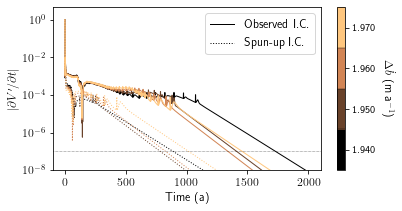

In [62]:
fig, ax = plt.subplots(1,1, figsize=(6,3), sharey=True)

for delta_mb in np.arange(1.94,1.97,0.01): 
    color = cmap_sub(norm_sub(delta_mb))

    ax.plot(OIC_sub.t, 
            np.abs(OIC_sub.sel(Delta_MB=delta_mb).differentiate('t')),  
            color=color,
            lw=1.0)
    ax.plot(SIC_sub.t, 
            np.abs(SIC_sub.sel(Delta_MB=delta_mb).differentiate('t')), 
            color=color,
            lw=1.0,
            ls=':')

# aditional lines
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-'),
                Line2D([0], [0], color='k', lw=1, ls=':')]

ax.legend(custom_lines, ['Observed I.C.', 'Spun-up  I.C.'], loc=1)

cbar = fig.colorbar(s_map_sub,
                spacing='proportional',
                ticks=OIC_sub.Delta_MB,
                ax=ax,
                boundaries=bounds_sub,
                drawedges=True,
                format='%2.{}f'.format(3))
# annotate the colorbar axes
cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize='small')
    
ax.set_ylabel(r'$\left| \partial V^{\prime} / \partial t \right|$')
ax.set_xlabel('Time (a)')

ax.set_yscale('log')
# Major ticks every 20, minor ticks every 5
# major_ticks = np.logspace(0, -8, 5)
# minor_ticks = np.logspace(0, -8, 9)
# ax.set_yticks(major_ticks);
# ax.set_yticks(minor_ticks, minor=True);


ax.axhline(1e-7, ls=':', c='k', lw=0.5)
ax.set_ylim(1e-8, None);
fig.savefig('../plots/farinotti_corrected/dx50/hysteresis/dVdt.png', dpi=400, bbox_inches='tight', facecolor='w')

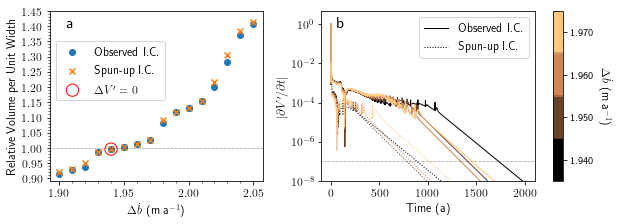

In [77]:
fig, ax = plt.subplots(1,2, figsize=(8.5,3), constrained_layout=True)

ax[0].scatter(OIC_vol.Delta_MB, OIC_vol.isel(t=-1),label='Observed I.C.')
ax[0].scatter(SIC_vol.Delta_MB, SIC_vol.isel(t=-1),label='Spun-up  I.C.',marker='x')


ax[0].scatter(OIC_vol.isel(Delta_MB=4).Delta_MB, 
           OIC_vol.isel(Delta_MB=4).isel(t=-1), 
           s=150, edgecolors='r', facecolor='None',
           label='$\Delta V\' = 0$')

ax[0].legend(loc=6, bbox_to_anchor=(0.0, 0.65))

ax[0].axhline(1.0, ls=':', c='k', lw=0.5)

ax[0].set_ylabel('Relative Volume per Unit Width')
ax[0].set_xlabel('$\Delta \dot b$ (m a$^{-1}$)')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(1.90, 2.051, 0.05)
minor_ticks = np.arange(1.90, 2.051, 0.01)
ax[0].set_xticks(major_ticks);
ax[0].set_xticks(minor_ticks, minor=True);

major_ticks = np.arange(0.9, 1.50, 0.05)
minor_ticks = np.arange(0.9, 1.45, 0.01)

ax[0].set_yticks(major_ticks);
ax[0].set_yticks(minor_ticks, minor=True);


########################
# Subplot 2: convergence 
########################
for delta_mb in np.arange(1.94,1.97,0.01): 
    color = cmap_sub(norm_sub(delta_mb))

    ax[1].plot(OIC_sub.t, 
            np.abs(OIC_sub.sel(Delta_MB=delta_mb).differentiate('t')),  
            color=color,
            lw=1.0)
    ax[1].plot(SIC_sub.t, 
            np.abs(SIC_sub.sel(Delta_MB=delta_mb).differentiate('t')), 
            color=color,
            lw=1.0,
            ls=':')

# aditional lines
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-'),
                Line2D([0], [0], color='k', lw=1, ls=':')]

ax[1].legend(custom_lines, ['Observed I.C.', 'Spun-up  I.C.'], loc=1)

cbar = fig.colorbar(s_map_sub,
                spacing='proportional',
                ticks=OIC_sub.Delta_MB,
                ax=ax,
                aspect=50,
                boundaries=bounds_sub,
                drawedges=True,
                format='%2.{}f'.format(3))
# annotate the colorbar axes
cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize='small')
    
ax[1].set_ylabel(r'$\left| \partial V^{\prime} / \partial t \right|$')
ax[1].set_xlabel('Time (a)')

ax[1].set_yscale('log')
# Major ticks every 20, minor ticks every 5
# major_ticks = np.logspace(0, -8, 5)
# minor_ticks = np.logspace(0, -8, 9)
# ax.set_yticks(major_ticks);
# ax.set_yticks(minor_ticks, minor=True);


ax[1].axhline(1e-7, ls=':', c='k', lw=0.5)
ax[1].set_ylim(1e-8, None);



ax[0].text(0.075, 0.9, 'a', transform=ax[0].transAxes, 
               fontsize=16, fontweight='bold')
ax[1].text(0.075, 0.9, 'b', transform=ax[1].transAxes, 
               fontsize=16, fontweight='bold')


fig.savefig('../plots/farinotti_corrected/dx50/hysteresis/Vol_and_dVdt_hysteresis.pdf')

Again, only $\Delta \dot{b} = 1.94-1.97$ converge to a steady-state for both initial conditions. Therefore, we only use these values to compute the time difference to reach steady state for the two different initial conditions. 

In [28]:
#convergence tolerance 
ϵ = 1e-7

# calculate the dVdt convergence metric for both I.C.'s 
# only use sims whic converge for both I.C.'s 
OIC_dvdt = np.abs(OIC_vol.sel(Delta_MB=np.arange(1.94,1.97,0.01)).differentiate('t'))
SIC_dvdt = np.abs(SIC_vol.sel(Delta_MB=np.arange(1.94,1.97,0.01)).differentiate('t'))

# function to find the first index where dVdt has converged
conv_idx = lambda x : (~np.isnan(x.where(x <= ϵ).groupby('Delta_MB'))).argmax('t').values

# find convergence index for each I.C. 
OIC_idx = conv_idx(OIC_dvdt)
SIC_idx = conv_idx(SIC_dvdt)

# calculate the percent difference 
percdif =  (SIC_idx-OIC_idx)/OIC_idx * 100


print('-'*100)
print('Obsevred I.C. takes (on average) {:2.1f}% percent longer '\
      'to converge as compared to Steady-State I.C.'.format(np.abs(np.mean(percdif))))
print('-'*100)

----------------------------------------------------------------------------------------------------
Obsevred I.C. takes (on average) 40.3% percent longer to converge as compared to Steady-State I.C.
----------------------------------------------------------------------------------------------------


Next, lets plot the final free surface $z_{\rm s}(t=2000)$ for both initial condition to compare the resulting ice-thickness distributions. 

In [ ]:
# Call the helper function to plot the free surface curves 
fig, ax, cbar = plot_spinup.plot_final_z_s(Observed_IC, precision=2, title=None)

# remove the inital condition, we will re-plot it below
ax.lines.pop(-1)

# get the colorbar used by the helper function 
cmap, norm, s_map, bounds = plot_spinup.make_colorbar(Observed_IC)

# loop over steadt-state initial condition results and plot with dotted line 
for delta_mb in SmoothBed_SS_IC.Delta_MB:
    color = cmap(norm(delta_mb))
    ax.plot(SmoothBed_SS_IC.x/1000., 
            SmoothBed_SS_IC.isel(t=-1).z_s.sel(Delta_MB=delta_mb), 
            color=color, ls=':')
    
# replot bed to block out foreland z_s
ax.plot(SmoothBed_SS_IC.x/1000., 
        SmoothBed_SS_IC.isel(t=0,Delta_MB=0).z_b, color='k', label=r'$z_{\rm b}$')

# plot the different initial conditions with different line styles 
ax.plot(Observed_IC.x/1000., 
        Observed_IC.isel(t=1,Delta_MB=0).z_s, 
        color='grey', zorder=0, 
        label=r'$z_{\rm b}$')

ax.plot(SmoothBed_SS_IC.x/1000., 
        SmoothBed_SS_IC.isel(t=1,Delta_MB=0).z_s, 
        color='grey', ls=':', zorder=0, 
        label=r'$z_{\rm b}$')

# Remove the default legened 
ax.get_legend().remove()

# aditional lines
custom_lines = [Line2D([0], [0], color=cmap(0), lw=1, ls='-'),
                Line2D([0], [0], color=cmap(0), lw=1, ls=':')]

ax.legend(custom_lines, ['Observed I.C.', 'Spun-up  I.C.'], loc=5)

# Adjust the y-lim
ax.set_ylim(1400, 2500)
# Adjust the x-lim
ax.set_xlim(0, 20)

# Adjust colorbar label fontsize 
cbar.ax.tick_params(labelsize='small')

# Adjust the figure size
fig.set_size_inches(9, 5)

fig.savefig('/Users/andrewnolan/Desktop/hystersis_z_s_test.png', dpi=400, bbox_inches='tight', facecolor='w')

Finally, lets to take a look in a little more detail at the difference it ice-thickness between the different initial conditions throughout the 2 kya spin-up simulation. 

In [ ]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

# calculate the % difference 
perc_diff = (SmoothBed_SS_IC.H.sel(Delta_MB=1.98) - Observed_IC.H.sel(Delta_MB=1.98)) \
            / Observed_IC.H.sel(Delta_MB=1.98)

# colorbar tweaking 
cmap = copy.copy(plt.matplotlib.cm.RdBu)
cmap.set_bad('grey',1.)

im = ax.pcolormesh(SmoothBed_SS_IC.x/1e3, 
                   SmoothBed_SS_IC.t,
                   perc_diff.T, 
                   shading='nearest', 
                   cmap='RdBu',
                   vmin=-1.0, vmax=1.0)

cbar = fig.colorbar(im)
cbar.set_label('\% difference', rotation=270, labelpad=15)

ax.set_xlim(None,18)
ax.set_xlabel('Length (km)')
ax.set_ylabel('Time (a)');